In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from subprocess import call
from joblib import Parallel, delayed
from keras import backend as K
from keras.layers import Dense
from keras.models import Model
from keras.optimizers import SGD
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
# from keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
%matplotlib inline
%load_ext watermark
%load_ext autoreload 
%autoreload 2

from recsys.utils import create_matrix

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,joblib,keras,sklearn,recsys

Using TensorFlow backend.


Ethen 2017-04-01 22:12:32 

CPython 3.5.2
IPython 5.1.0

numpy 1.12.1
pandas 0.19.2
matplotlib 2.0.0
joblib 0.11
keras 2.0.1
sklearn 0.18.1
recsys 0.0.1


In [2]:
data = pd.read_csv('model_likes.csv', quotechar = '\\', encoding = 'latin1')
data['interactions'] = 1
print(data.shape)
data.head()

(379336, 7)


,mid,uid,name,thumbnail,url,category,interactions
0,8609caf1cd8c452eb7b6d4ca4228fcd0,c3d22af246056d258c3493582fbf378f,Firewatch Fan Art,https://dg5bepmjyhz9h.cloudfront.net/urls/8609...,https://sketchfab.com/models/8609caf1cd8c452eb...,Architecture,1
1,8609caf1cd8c452eb7b6d4ca4228fcd0,6e795101ca8f455070b908a193500410,Firewatch Fan Art,https://dg5bepmjyhz9h.cloudfront.net/urls/8609...,https://sketchfab.com/models/8609caf1cd8c452eb...,Architecture,1
2,8609caf1cd8c452eb7b6d4ca4228fcd0,21f84161b0a59f1f05d298c523002fcd,Firewatch Fan Art,https://dg5bepmjyhz9h.cloudfront.net/urls/8609...,https://sketchfab.com/models/8609caf1cd8c452eb...,Architecture,1
3,8609caf1cd8c452eb7b6d4ca4228fcd0,21f75b7330fb937f8d905e54f903c1b4,Firewatch Fan Art,https://dg5bepmjyhz9h.cloudfront.net/urls/8609...,https://sketchfab.com/models/8609caf1cd8c452eb...,Architecture,1
4,8609caf1cd8c452eb7b6d4ca4228fcd0,be8276038689010a47e0c512b5247d13,Firewatch Fan Art,https://dg5bepmjyhz9h.cloudfront.net/urls/8609...,https://sketchfab.com/models/8609caf1cd8c452eb...,Architecture,1


In [3]:
item_col = 'mid'
user_col = 'uid'
rating_col = 'interactions'
user_threshold = 3
item_threshold = 3
X, data, removed_users, removed_items = create_matrix(data, user_col, item_col, rating_col,
                                                      user_threshold, item_threshold)
X

<12826x15850 sparse matrix of type '<class 'numpy.int32'>'
	with 332446 stored elements in Compressed Sparse Row format>

In [4]:
img_dir = 'thumbnails'
unique_categories = data['category'].unique()
unqiue_data = data[['mid', 'category']].drop_duplicates()
X_train, X_validation = train_test_split(unqiue_data, test_size = 0.2, 
                                         random_state = 1234, stratify = unqiue_data['category'])
# keras' way of organizing the files
keras_dir = 'thumbnails-data'
if not os.path.isdir(keras_dir):
    os.mkdir(keras_dir)

In [5]:
def make_keras_file(mid, category, img_dir, data_dir):
    file_name = mid + '.jpg'
    file_path = os.path.join(img_dir, file_name)
    save_path = os.path.join(data_dir, category, file_name)
    call(['cp', file_path, save_path])

def make_all_keras_file(data, keras_dir, img_dir, folder_name, unique_categories,
                        n_jobs = -1, verbose = True, pre_dispatch = '2*n_jobs'):
    data_dir = os.path.join(keras_dir, folder_name)
    if not os.path.isdir(data_dir):
        os.mkdir(data_dir)
    
    for category in unique_categories:
        category_dir = os.path.join(data_dir, category)
        if not os.path.isdir(category_dir):
            os.mkdir(category_dir)
        
    mids = data['mid'].values
    categories = data['category'].values
    parallel = Parallel(n_jobs = n_jobs, verbose = verbose, pre_dispatch = pre_dispatch)
    parallel(delayed(make_keras_file)(mid, category, img_dir, data_dir) 
             for mid, category in zip(mids, categories))
        
    return data_dir

In [6]:
folder_name = 'train'
train_data_dir = make_all_keras_file(X_train, keras_dir, img_dir, folder_name, unique_categories)
folder_name = 'validation'
validation_data_dir = make_all_keras_file(X_validation, keras_dir, img_dir, folder_name, unique_categories)  

[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4994 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 7701 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 9161 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 10661 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 12297 out of 12680 | elapsed:   10.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 12680 out of 12680 | elapsed:   10.9s finished
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3170 out of 3170 | elapsed:    2.4s finished


## Transfer Learning

In [7]:
# dimensions of our images (matching VGG architecture)
target_size = 224, 224
epochs = 2
batch_size = 100

# tensorflow/theano input shape compatibility
if K.image_data_format() == 'channels_first':
    input_shape = 3, *target_size
else:
    input_shape = *target_size, 3

In [8]:
n_classes = unique_categories.shape[0]
vgg16 = VGG16(weights = 'imagenet')
fc2 = vgg16.get_layer('fc2').output
prediction = Dense(n_classes, activation = 'softmax', name = 'softmax')(fc2)
model = Model(inputs = vgg16.inputs, outputs = prediction)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
for layer in model.layers:
    if layer.name in ['fc1', 'fc2', 'softmax']:
        continue
    layer.trainable = False
    
sgd = SGD(lr = 1e-4, momentum = 0.9)
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    
def color_trainable_red(val):
    """
    returns a string with the css property 
    `'background-color: yellow'` for trainable 
    layers, read otherwise
    """
    color = 'yellow' if val else 'red'
    return 'background-color: %s' % color
    
df = pd.DataFrame(([layer.name, layer.trainable] for layer in model.layers), columns = ['layer', 'trainable'])
df = df.style.applymap(color_trainable_red, subset = ['trainable'])
df

In [ ]:
def preprocess_input_vgg(x):
    """Wrapper around keras.applications.vgg16.preprocess_input()
    to make it compatible for use with keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument.
    
    Parameters
    ----------
    x : a numpy 3darray (a single image to be preprocessed)
    
    Note we cannot pass keras.applications.vgg16.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.
    
    Returns a numpy 3darray (the preprocessed image).
    
    """
    X = np.expand_dims(x, axis = 0)
    X = preprocess_input(X)
    return X[0]


datagen = ImageDataGenerator(preprocessing_function = preprocess_input_vgg)
train_generator = datagen.flow_from_directory(directory = train_data_dir,
                                              target_size = target_size,
                                              batch_size = batch_size,
                                              class_mode = 'categorical')
validation_generator = datagen.flow_from_directory(directory = validation_data_dir,
                                                   target_size = target_size,
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical')

Found 12680 images belonging to 10 classes.
Found 3170 images belonging to 10 classes.


In [ ]:
model.fit_generator(train_generator,
                    steps_per_epoch = X_train.shape[0] // batch_size,
                    epochs = epochs,
                    validation_data = validation_generator,
                    validation_steps = X_validation.shape[0] // batch_size)

Epoch 1/2


In [ ]:
from IPython.display import display
import matplotlib.pyplot as plt

X_val_sample, _ = next(validation_generator)
y_pred = model.predict(X_val_sample)

nb_sample = 4
for x, y in zip(X_val_sample[:nb_sample], y_pred.flatten()[:nb_sample]):
    s = pd.Series({'Cat': 1-y, 'Dog': y})
    axes = s.plot(kind='bar')
    axes.set_xlabel('Class')
    axes.set_ylabel('Probability')
    axes.set_ylim([0, 1])
    plt.show()

    img = array_to_img(x)
    display(img)

In [ ]:
categories = data[item_col].cat.categories

In [2]:
def preprocess_img(img_path, target_size):
    """"""
    img = load_img(img_path, target_size = target_size)
    x = img_to_array(img)
    return x

def preprocess_all_img(categories, img_dir, n_jobs = -1, , verbose = True, pre_dispatch = '2*n_jobs'):        
    current_path = os.getcwd()
    os.chdir(img_dir)
    
    target_size = 224, 224
    
    parallel = Parallel(n_jobs = n_jobs, verbose = verbose, pre_dispatch = pre_dispatch)
    x = parallel(delayed(preprocess_img)(img_names + '.jpg', target_size) for img_names in categories)
    os.chdir(current_path)
    
    X_img = np.asarray(x)
    X_img = preprocess_input(X_img)
    return X_img

In [3]:
# preprocess_input from imagenet_utils is for ResNet only, not for Inception and Xception net.
img_features_path = 'img_features.pkl'
if not os.path.exists(img_features_path):
    X_img = preprocess_all_img(categories, img_dir)
    
    # getting the image feature takes a while (6000 seconds?)
    base_model = VGG19(weights = 'imagenet')
    model = Model(inputs = base_model.inputs, outputs = base_model.get_layer('fc2').output)
    img_features = model.predict(X_img, verbose = 1)
    joblib.dump(img_features, img_features_path)

# img features is a sparse matrix ????
img_features = joblib.load(img_features_path)
img_features.shape

(19836, 4096)

In [4]:
def get_similar_items(item_factors, N = 5, item_ids = None):
    """
    return the top N similar items for itemid, where
    cosine distance is used as the distance metric

    Parameters
    ----------
    N : int, default 5
        top-N similar items' N

    item_ids : 1d iterator, e.g. list or numpy array, default None
        the item ids that we wish to find the similar items
        of, the default None will compute the similar items
        for all the items

    Returns
    -------
    similar_items : 2d numpy array [number of query item_ids, N]
        each row is the top-N most similar item id for each
        query item id
    """
    # cosine distance is proportional to normalized euclidean distance,
    # thus we normalize the item vectors and use euclidean metric so
    # we can use the more efficient kd-tree for nearest neighbor search;
    # also the item will always to nearest to itself, so we add 1 to 
    # get an additional nearest item and remove itself at the end
    normed_item_factors = normalize(item_factors)
    knn = NearestNeighbors(n_neighbors = N + 1, metric = 'euclidean', n_jobs = -1)
    knn.fit(normed_item_factors)

    # returns a distance, index tuple,
    # we don't actually need the distance
    if item_ids is not None:
        normed_item_factors = normed_item_factors[item_ids]

    _, items = knn.kneighbors(normed_item_factors)
    similar_items = items[:, 1:].astype(np.int32)
    return similar_items

In [6]:
start = time()
similar_items = get_similar_items(img_features)
print(time() - start)
similar_items.shape

265.38813376426697


(19836, 5)

In [26]:
def report(similar_items, categories, query_id, img_dir = ''):
    """
    given a query id print the item name, and
    the recommended item names
    """
    item_id = categories[query_id]
    print('Query:\n')
    path = os.path.join(img_dir, item_id + '.jpg')
    img = plt.imread(path)
    plt.figure()
    plt.imshow(img)
    print('\nSimilar Items:\n')
    for item_id in similar_items[query_id]:
        path = os.path.join(img_dir, categories[item_id] + '.jpg')
        plt.figure()
        img = plt.imread(path)
        plt.imshow(img)

Query:


Similar Items:



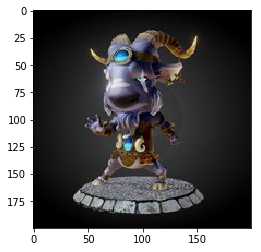

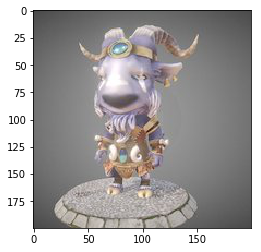

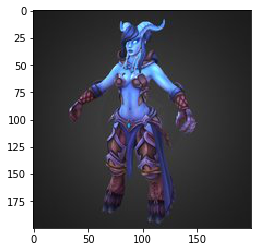

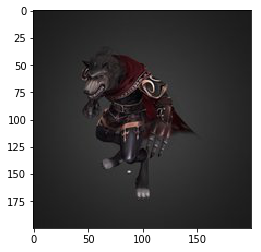

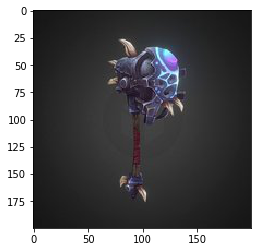

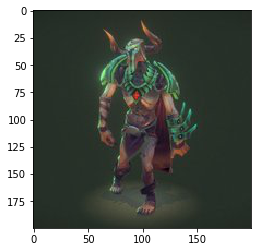

In [27]:
query_id = 0
report(similar_items, categories, query_id, img_dir)

Query:


Similar Items:



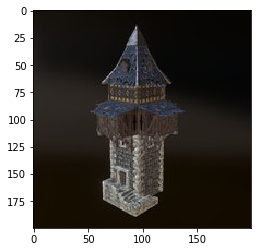

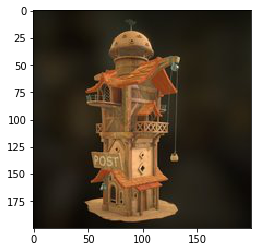

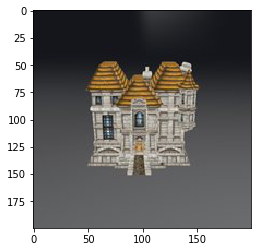

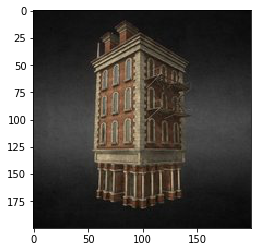

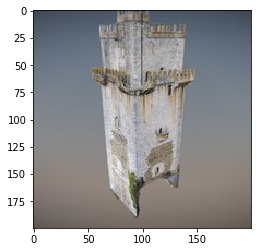

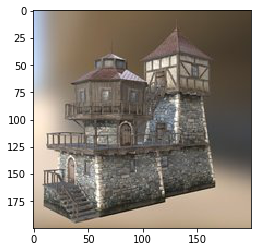

In [31]:
query_id = 500
report(similar_items, categories, query_id, img_dir)

http://blog.ethanrosenthal.com/2016/12/05/recasketch-keras/